# Trabalho Prático 1 - Aplicação de redes neuronais a um novo dataset
Objetivo: Explorar o uso de redes neuronais (keras) e comparação dos resultados com o uso de [AutoKeras](https://autokeras.com/).

Tipo de tarefa machine learning: Classificação Binária.

Dataset utilizado: [Titanic](https://public.opendatasoft.com/explore/dataset/titanic-passengers)

Repositório: [GitHub](https://github.com/spamz23/Applied-Deep-Learning/tree/005e14f8c27e176ac310183a5a2216c8838f2abc/Practical%20Work%201)

Trabalho realizado por:
* [Diogo Silva](https://github.com/spamz23)
* [Bruno Silva](https://github.com/brunosilva5)

# Instalar dependências

In [1201]:
!pip install -r requirements.txt
# Limpar output
from IPython.display import clear_output
clear_output()

# Resultados Reproduzíveis
Para uma comparação justa entre os resultados de 2 técnicas diferentes, é importante que os resultados de ambas as técnicas sejam **reproduzíveis**. Para isto podemos fazer "seed" nos geradores de números aleatórios usados no backend da biblioteca `keras`.

In [1202]:
global_seed = 0 # pode ser qualquer número
from numpy.random import seed
seed(global_seed)
import tensorflow as tf
tf.random.set_seed(global_seed)

## 1. Fazer load dos dados
Para fazer load e tratar os dados, será utilizada a biblioteca pandas.

In [1203]:
import pandas as pd

index = "PassengerId"
dataset = pd.read_excel("titanic-passengers.xlsx", index_col="PassengerId")


### Primeiro é importante analisar e perceber a estrutura dos dados

In [1204]:
dataset

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
431,Yes,1,"Bjornstrom-Steffansson, Mr. Mauritz Hakan",male,28.0,0,0,110564,26.5500,C52,S
664,No,3,"Coleff, Mr. Peju",male,36.0,0,0,349210,7.4958,NaN,S
44,Yes,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.0,1,2,SC/Paris 2123,41.5792,NaN,C
347,Yes,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S
891,No,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
779,No,3,"Kilgannon, Mr. Thomas J",male,NaN,0,0,36865,7.7375,NaN,Q
435,No,1,"Silvey, Mr. William Baird",male,50.0,1,0,13507,55.9000,E44,S
342,Yes,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S


### Informações obtidas
Na tabela acima podemos observar que o dataset de treino é composto por 891 linhas (cada linha corresponde a uma pessoa), e por 11 colunas.
Podemos então tirar as seguintes conclusões:
1. Existem várias colunas com variáveis categóricas (`Name`, `Sex`, `Ticket`, `Cabin`, `Embarked`). Todas estas terão que ser convertidas para números para se poderem usar na rede neuronal.
2. Existem algumas colunas com valores `NaN`, ou seja valores em falta. Todas estas também terão que se preencher, ou então remover do dataset.
3. A coluna `Survived`, tem apenas valores binários (`0` e `1`). Esta indica se a pessoa em questão sobreviveu (`1`) ou não (`0`). O objetivo da rede neuronal será prever os valores desta coluna. Esta coluna terá que ser separada das restantes, para que seja utilizada como output.


# 2. Tratamento dos dados
Tal como referido anteriormente existem "problemas" nos dados, que terão de ser resolvidos antes de os aplicar numa rede neuronal.

## 2.1 Valores em falta

Para saber quais as colunas que contêm valores `NaN` podemos utilizar o seguinte código:

In [1205]:
print(f"Colunas com valores 'NaN': {dataset.columns[dataset.isna().any()].tolist()}")

Colunas com valores 'NaN': ['Age', 'Cabin', 'Embarked']


Podemos observar que existem 3 colunas com valores `NaN`: `Age`, `Cabin` e `Embarked`

### 2.1.1 Coluna 'Cabin'

In [1206]:
missing = dataset["Cabin"].isnull().sum(axis=0)
total = dataset.shape[0]

print(f"Percentagem de valores em falta na coluna 'Cabin': {(missing*100)/total:.2f} %")

Percentagem de valores em falta na coluna 'Cabin': 77.10 %


Como 77.10 % dos dados, na coluna `Cabin`, estão em falta, iremos proceder à remoção desta coluna, pois a sua inclusão provavelmente não se iria traduzir num ganho de informação na rede neuronal.

In [1207]:
dataset.drop(columns=['Cabin'], inplace=True)

### 2.1.2 Coluna 'Embarked'

In [1208]:
missing = dataset["Embarked"].isnull().sum(axis=0)
total = dataset.shape[0]

print(f"Percentagem de valores em falta na coluna 'Embarked': {(missing*100)/total:.2f} %")

Percentagem de valores em falta na coluna 'Embarked': 0.22 %


Como nesta coluna apenas estão em falta apenas 0.22 % dos dados (o que corresponde a 2 linhas) e trata-se de uma variável categórica, iremos preencher os valores em falta com o valor mais frequente nesta coluna. Para isto iremos utilizar o módulo [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) disponibilizado pela biblioteca [scikit-learn](https://scikit-learn.org/).

In [1209]:
from sklearn.impute import SimpleImputer
import numpy as np
# Criar objeto imputer com estratégia 'most_frequent'
imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent', verbose=0)
# Aplicar na coluna 'Embarked'. Como vamos aplicar apenas a uma coluna, e o método espera um array 2D, é necessário fazer um reshape dos dados
dataset["Embarked"] = imp_most_frequent.fit_transform(dataset["Embarked"].values.reshape(-1, 1))

### 2.1.3 Coluna 'Age'

In [1210]:
missing = dataset["Age"].isnull().sum(axis=0)
total = dataset.shape[0]

print(f"Percentagem de valores em falta na coluna 'Age': {(missing*100)/total:.2f} %")

Percentagem de valores em falta na coluna 'Age': 19.87 %


Nesta coluna estão em falta 19.87 % e trata-se de uma variável numérica, iremos preencher os valores em falta com o valor médio da coluna `Age`. Para isto iremos utilizar o mesmo módulo utilizado na coluna anterior. Existem 2 metodologias possíveis para o preenchimento de variáveis numéricas:
1. Utilizar a média dos valores da coluna;
2. Utilizar a mediana dos valores da coluna.
Para decidir qual a melhor estratégia é necessário observar a curva de distribuição dos dados desta coluna (`Age`).

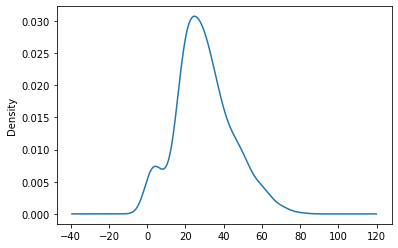

In [1211]:
dataset["Age"].plot.kde()

Como é possível observar na figura acima, os dados não seguem uma distribuição normal. Assim concluímos que será mais vantajoso utilizar a mediana para o preenchimento dos valores em falta.

In [1212]:
from sklearn.impute import SimpleImputer
import numpy as np
# Criar objeto imputer com estratégia 'median'
imp_median = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0)
# Aplicar na coluna 'Age'. Como vamos aplicar apenas a uma coluna, e o método espera um array 2D, é necessário fazer um reshape dos dados
dataset["Age"] = imp_median.fit_transform(dataset["Age"].values.reshape(-1, 1))

## 2.2 Transformar valores categóricos em valores numéricos

Para saber quais as colunas que contêm valores não numéricos podemos utilizar o seguinte código:

In [1213]:
non_numeric_columns = dataset.columns.difference(dataset._get_numeric_data().columns).to_list()
print(f"Colunas não númericas: {non_numeric_columns}")

Colunas não númericas: ['Embarked', 'Name', 'Sex', 'Survived', 'Ticket']


### 2.2.1 Coluna 'Embarked', 'Sex', 'Name', 'Ticket'
Em primeiro lugar iremos remover as colunas `Name` e `Ticket`, pois estas são únicas dos passageiros.
Para transformar os valores das restantes colunas (`Embarked`, `Sex`) em valores numéricos iremos utilizar o método `get_dummies()` da biblioteca `pandas`. Este método irá criar, para cada coluna, novas `n` colunas, onde `n` é o numero de diferentes classes presentes em cada coluna. Estas novas colunas irão conter valores binários que indicam se uma linha pertence ou não a essa classe. 

Uma outra alternativa mais simples seria transformar, para cada coluna, cada classe diferente num valor inteiro diferente. Apesar de ser mais simples, esta tranformação poderia introduzir uma falsa sensação de hierarquiedade nos dados, o que poderia levar a rede neuronal a aprender falsas suposições. 

In [1214]:
dataset.drop(columns=["Name", "Ticket"], inplace=True)
# Fazer OneHotEncoding para todas as colunas não numéricas, excepto a coluna 'Survived'
dataset = pd.get_dummies(dataset, columns=["Embarked", "Sex"])

### 2.2.2 Coluna 'Survived'
As transformações a esta coluna são simples. Esta apenas contêm os valores `Yes` ou `No`. Apenas temos que transformar estes valores para `1` ou `0`, respetivamente.

In [1215]:
dataset["Survived"] = dataset['Survived'].map({'Yes': 1, 'No': 0})

## 2.3 Criar novos 'features' a partir de existentes
No dataset existe a coluna `SibSp` que indica o número de irmãos/cônjuges, do passageiro, a bordo. Existe também a coluna `Parch` que indica o número de pais/filhos, do passageiro, a bordo.
Como estas 2 colunas estão intrinsecamente relacionadas, decidimos uni-las numa só coluna, a que chamamos de `Family_Members`, que indica o número total de familiares a bordo do navio.

In [1216]:
# União das colunas
dataset["Family_Members"] = dataset["SibSp"] + dataset["Parch"]
# Apagar colunas que já não são necessárias
dataset.drop(columns=["SibSp", "Parch"], inplace=True)

## 2.4 Separação da coluna 'Survived'
É também importante separar a coluna `Survived` do resto do dataset. Iremos criar 2 variáveis,  `X`  (irá conter os dados), e `y` (irá conter a coluna `Survived`)

In [1217]:
X = dataset[dataset.columns.difference(["Survived"])]
y = dataset[["Survived"]]

## 2.5 Normalização de dados
Para que o modelo tenha uma maior performance, por vezes, é fundamental fazer a normalização dos dados. 
O objetivo da normalização é alterar os valores das colunas numéricas no conjunto de dados para uma escala comum, sem distorcer as diferenças no intervalos de valores.
Neste dataset, como existe uma diferença significativa na escala dos valores, como por exemplo, na coluna `Pclass`, onde os valores variam entre 1 e 3, e as colunas `Age` e `Fare` que variam de `0` a `80` e `0` a `512`, respetivamente, é fundamental normalizar os dados pois os intervalos são muito diferentes.

In [1218]:
from sklearn.preprocessing import StandardScaler

# Definir colunas a normalizar
cols = ["Pclass", "Age", "Family_Members", "Fare"]
# Normalizar os dados
scaled_columns = StandardScaler().fit_transform(X[cols].values)
# Juntar os dados normalizados com os outros
X = np.concatenate([X[X.columns.difference(cols)], scaled_columns], axis=1)


## 2.6 Divisão dos dados

É fundamental fazer a divisão do dataset em dados de treino e dados de teste, de modo a poder avaliar a verdadeira capacidade de generalização, esta deve conseguir prever corretamente dados que nunca tenha visto.
Uma metodologia bastante comum, é usar 80% dos dados para treinar o modelo e os restantes para avaliar a sua qualidade.

In [1219]:
from sklearn.model_selection import train_test_split
# Dividir dados em treino e teste. 
# 20% dos dados são usados para teste
# random_state = 42, para resultados reproduzíveis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = global_seed)

# 3. Construir e treinar as Redes Neuronais

In [1220]:
# Método para apresentar diferentes métricas de avaliação dos modelos
def print_test_results(y_test, y_predict_proba):
    # Gerar previsões de classes
    y_predict = (y_predict_proba > 0.5).astype(np.int32)
    # Comparar previsões com valores reais
    print("Métricas obtidas nos dados de teste:")
    print(f"ROC Auc: {sk_metrics.roc_auc_score(y_test, y_predict_proba):.2f}")
    print(f"Accuracy: {sk_metrics.accuracy_score(y_test, y_predict):.2f}")
    print(f"F1 Score: {sk_metrics.f1_score(y_test, y_predict):.2f}")
    print(f"Precision: {sk_metrics.precision_score(y_test, y_predict):.2f}")

## 3.1 Construção manual de rede neuronal Keras

Para usar os dados no tensorflow devemos converter os dados de numpy para formato nativo do tensorflow.

Primeiro iremos construir uma rede simples, e verificar se esta tem algum poder de generalização para os dados não vistos. Depois iremos gradualmente aumentar a complexidade da rede, verificando o seu novo desempenho a cada etapa.
Iremos definir alguns métodos que serão usados por todas as redes contruidas.
Em baixo iremos definir 2 *callbacks* (métodos que serão chamados a cada *epoch*):


*   `EarlyStopping` para prevenir treino excessivo, e reduzir o *overfitting*;



In [1242]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import matplotlib.pyplot as plt
import tensorflow as tf


def get_callbacks(name):
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_auroc', patience=200),
  ]

De seguida podemos também definir um método `compile_fit` que será reutilizado por todos os modelos. Este método irá compilar e treinar cada modelo.

In [1243]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

def compile_fit(model, name, max_epochs=10000):
  
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[auroc])
  model.summary()

  history = model.fit(
    X_train,
    y_train,
    epochs=max_epochs,
    validation_split=0.15, # 15% para validação
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [1244]:
# Dicionário para guardar os históricos de treino
history={}

### Modelo 1
Podemos então criar o nosso primeiro modelo com apenas 2 camadas e poucos neurónios.

In [1245]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation = 'sigmoid') # apenas um neurónio para output de 0 ou 1
])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


(0.5, 1.0)

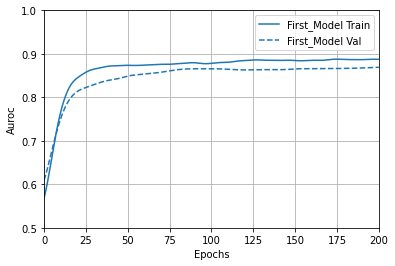

In [1246]:
# Adicionar ao dicionário
history["first_model"] = compile_fit(model_1, "first_model")
# Podemos fazer o plot do treino do modelo
# Criar plotter
plotter = tfdocs.plots.HistoryPlotter(metric = 'auroc', smoothing_std=10)
# Fazemos plot do historico de treino
plotter.plot(history)
plt.ylim([0.5, 1]) # Apenas de 0.5 para cima


**Resultados nos dados de teste:**

In [1226]:
print_test_results(y_test, model_1.predict(X_test))


Métricas obtidas nos dados de teste:
ROC Auc: 0.88
Accuracy: 0.83
F1 Score: 0.74
Precision: 0.75


Como podemos observar no gráfico acima, o valor de validação da métrica escolhida (`AUROC`) mantém-se equivalente ao de treino. Podemos tentar melhorar a performance aumentando o número de camadas da rede, o que irá aumentar o número de parâmetros treináveis, aumentado a capacidade de aprendizagem da rede.

### Modelo 2
Adicionamos mais uma camada, e aumentamos o número de neurónios para `32`.

In [1227]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid') # apenas um neurónio para output de 0 ou 1
])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


(5.0, 200.0)

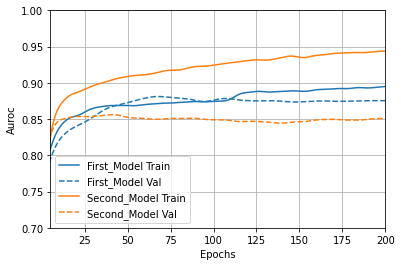

In [1228]:
# Adicionar ao dicionário
history["second_model"] = compile_fit(model_2, "second_model")

# Fazemos plot do historico de treino
plotter.plot(history)
plt.ylim([0.7, 1]) # Apenas de 0.7 para cima
plt.xlim([5, max(plt.xlim())])

**Resultados nos dados de teste:**

In [1229]:
print_test_results(y_test, model_2.predict(X_test))


Métricas obtidas nos dados de teste:
ROC Auc: 0.83
Accuracy: 0.77
F1 Score: 0.69
Precision: 0.63


Como podemos observar o segundo modelo construído (um modelo mais complexo) começou rapidamente a sofrer de overfit (o valor da métrica de validação rapidamente divergiu do valor de treino). Isto indica-nos que o modelo tem pior capacidade de generalização, o que é possível constatar pelos piores resultados obtidos nos dados de teste.
Veremos agora o desempenho de uma rede ainda maior.


### Modelo 3
Aumentamos as camadas e o número de neurónios para 64.

In [1230]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid') # apenas um neurónio para output de 0 ou 1
])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


(5.0, 200.0)

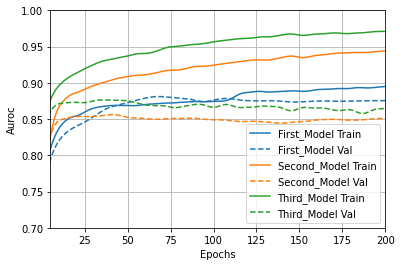

In [1231]:
# Adicionar ao dicionário
history["third_model"] = compile_fit(model_3, "third_model")

# Fazemos plot do historico de treino
plotter.plot(history)
plt.ylim([0.7, 1]) # Apenas de 0.7 para cima
plt.xlim([5, max(plt.xlim())])

**Resultados nos dados de teste:**

In [1232]:
print_test_results(y_test, model_3.predict(X_test))


Métricas obtidas nos dados de teste:
ROC Auc: 0.81
Accuracy: 0.79
F1 Score: 0.69
Precision: 0.68


**Podemos então agora aplicar estratégias para prevenir o Overfitting:**
* Aplicar regularização: Esta estratégia penaliza os parâmetros da rede neuronal com valores altos.

In [1233]:
# Importar regularizadores
from tensorflow.keras import regularizers
# Igual ao modelo 3 mas com regularizalão 'l2'
model_3_l2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', 
                          kernel_regularizer=regularizers.l2(0.003), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid') # apenas um neurónio para output de 0 ou 1
])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 9,025
Trainable params: 9,025
Non-trainable params: 0
_________________________________________________________________


(5.0, 200.0)

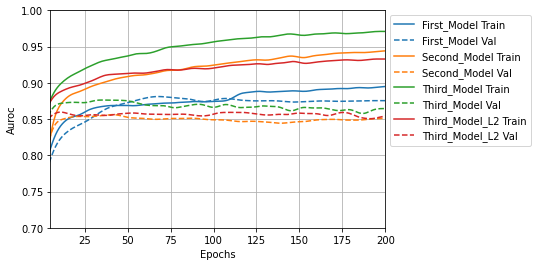

In [1234]:
# Adicionar ao dicionário
history["third_model_l2"] = compile_fit(model_3_l2, "third_model_l2")

# Fazemos plot do historico de treino
plotter.plot(history)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.ylim([0.7, 1]) # Apenas de 0.7 para cima
plt.xlim([5, max(plt.xlim())])

**Resultados nos dados de teste:**

In [1235]:
print_test_results(y_test, model_3_l2.predict(X_test))

Métricas obtidas nos dados de teste:
ROC Auc: 0.84
Accuracy: 0.80
F1 Score: 0.71
Precision: 0.68


* Aplicar Dropout: O `Dropout` é uma das técnicas mais utilizadas para combater o overfitting. Consiste em cortar aleatoriamente ligações entre neurónios.

In [1236]:

# Igual ao modelo 3 mas com regularização 'l2' e camadas dropout
model_3_l2_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', 
                          kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid') # apenas um neurónio para output de 0 ou 1
])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                640       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

(5.0, 200.0)

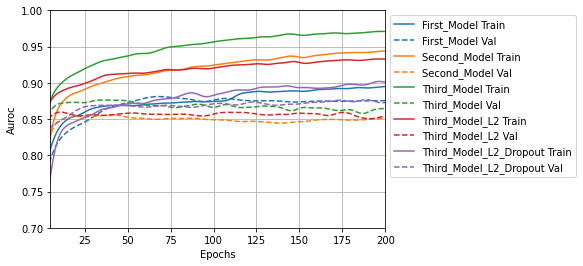

In [1237]:
# Adicionar ao dicionário
history["third_model_l2_dropout"] = compile_fit(model_3_l2_dropout, "third_model_l2_dropout")

# Fazemos plot do historico de treino
plotter.plot(history)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.ylim([0.7, 1]) # Apenas de 0.7 para cima
plt.xlim([5, max(plt.xlim())])

**Resultados nos dados de teste:**

In [1238]:
print_test_results(y_test, model_3_l2_dropout.predict(X_test))

Métricas obtidas nos dados de teste:
ROC Auc: 0.88
Accuracy: 0.83
F1 Score: 0.75
Precision: 0.73


Como podemos observar no gráfico acima a última rede construída (mais complexa) obteve um desempenho bastante similar à primeira rede (mais simples). Podemos também comprovar isto através da análise dos valores das métricas obtidas nos dados de teste. Ambos apresentaram valores muito próximos.
Com base no princípio de [Occam's Razor](https://pt.wikipedia.org/wiki/Navalha_de_Ockham), em caso de dúvida devemos optar pelo modelo mais simples. Este permite resultados bastante semelhantes, com a vantagem de um custo computacional significativamente mais baixo, assim como um menor tempo de treino.

| Modelo | ROC Auc | Accuracy | F1 Score | Precision
|:---:|:---:|:---:|:---:|:---:|
| Modelo 1 | 0.88 | 0.83 | 0.74 | **0.75** | 
| Modelo 3 (com L2 e Dropout) |  0.88 | 0.83 | **0.75** | 0.73 | 

## 3.2 Uso do `AutoKeras`
A biblioteca `AutoKeras` é uma biblioteca de AutoML (*Automated Machine Learning*), e pretende tornar o uso de *machine learning* acessível a todos. 

O seu objetivo é abstrair um utilizador da escolha dos vários hyper-parâmetros de uma rede neuronal, bem como da sua arquitetura. Esta biblioteca experimenta `n` redes com configurações diferentes, e escolhe automaticamente a que melhor se adapta aos dados, ou seja a que tiver melhor capacidade de generalização.

In [1239]:
import autokeras as ak

# Construir modelo
auto_model = ak.StructuredDataClassifier(
    overwrite=True,
    seed=global_seed,
    max_trials=20) # Experimenta 20 modelos diferentes

# Prepapar dados
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
# Treinar modelo
auto_model.fit(X_train, y_train, epochs=120)
# Exportar modelo AutoKeras para modelo Keras
auto_model = auto_model.export_model()

# Prever probabilidades
y_predict_proba = auto_model.predict(X_test)
# Apresentar resultados
print_test_results(y_test, y_predict_proba)



Trial 20 Complete [00h 00m 03s]
val_accuracy: 0.625

Best val_accuracy So Far: 0.8269230723381042
Total elapsed time: 00h 02m 37s
INFO:tensorflow:Oracle triggered exit
Epoch 1/120
23/23 [==============================] - 0s 3ms/step - loss: 0.7923 - accuracy: 0.5871
Epoch 2/120
23/23 [==============================] - 0s 3ms/step - loss: 0.6661 - accuracy: 0.6615
Epoch 3/120
23/23 [==============================] - 0s 3ms/step - loss: 0.6243 - accuracy: 0.7107
Epoch 4/120
23/23 [==============================] - 0s 3ms/step - loss: 0.5797 - accuracy: 0.7331
Epoch 5/120
23/23 [==============================] - 0s 3ms/step - loss: 0.5650 - accuracy: 0.7331
Epoch 6/120
23/23 [==============================] - 0s 3ms/step - loss: 0.5762 - accuracy: 0.7486
Epoch 7/120
23/23 [==============================] - 0s 3ms/step - loss: 0.5319 - accuracy: 0.7654
Epoch 8/120
23/23 [==============================] - 0s 3ms/step - loss: 0.5466 - accuracy: 0.7654
Epoch 9/120
23/23 [=====================

### Comparação de resultados
Na seguinte tabela podemos observar as diferentes métricas obtidas por ambos os modelos:

| Modelo | ROC Auc | Accuracy | F1 Score | Precision
|:---:|:---:|:---:|:---:|:---:|
| Modelo 1 |  0.88 | 0.83 | 0.74 | 0.75 |
| Modelo `AutoKeras` |  0.86 | 0.84 | 0.75 | 0.81 | 

Como é possível observar, ambos os modelos apresentaram resultados bastantes semelhantes.

No também pode ser também interessante observar ambas as arquiteturas das duas redes criadas.



**Estrutura Primeiro modelo:**

In [1240]:
# Resumir primeiro modelo
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


**Estrutura Modelo `AutoKeras`:**

In [1241]:
# Resumir modelo `AutoKeras`
auto_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 9)                 0         
_________________________________________________________________
dense (Dense)                (None, 512)               5120      
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)               

**Diferenças encontradas:**

Como podemos observar a rede neuronal construída pela biblioteca `AutoKeras` apresenta um nível de complexidade muito superior à rede neuronal construída manualmente. Enquanto a primeira rede apresenta 89 parâmetros treináveis, a segunda conta com 14.401 parâmetros treináveis.

Portanto, tal como se verificou anteriormente, no presente contexto não se justificaria a escolha da segunda rede neuronal. 
A adoção de uma rede neuronal construída manualmente oferece ainda a vantagem de um maior controlo sobre todo o processo. No entanto é de notar que foram experimentados apenas `20` modelos diferentes pelo `AutoKeras`. Um aumento no número de experiências realizadas poderia traduzir-se na construção de um melhor modelo. O uso do `AutoKeras` é também uma ferramenta aconselhável a iniciantes de *machine learning*, pois abstrai o utilizador dos complicados conceitos matemáticos intrínsecos deste tópico.
